## 1. Introduzione al Function Calling




### Cos'è il Function Calling?

Il function calling (noto anche come tool use) rappresenta un'evoluzione fondamentale nell'utilizzo dei Large Language Models. Tradizionalmente, un LLM poteva solo generare testo basandosi sulla sua conoscenza pre-addestrata. Con il function calling, invece, l'LLM diventa capace di interagire attivamente con sistemi esterni.

**Cosa Può Fare un LLM con Function Calling:**

- **Interrogare database** - Recuperare dati aggiornati da MySQL, PostgreSQL, SQLite
- **Chiamare API** - Ottenere meteo, prezzi azionari, tradurre testi, etc.
- **Eseguire calcoli** - Operazioni matematiche complesse, statistiche, simulazioni
- **Accedere ai file** - Leggere documenti, processare CSV, analizzare log
- **Eseguire azioni** - Inviare email, creare ticket, aggiornare record

**Esempio Pratico:**

Senza function calling:
```text
Utente: "Qual è il prezzo delle azioni Apple oggi?"
LLM: "Non ho accesso a dati in tempo reale, ma al momento del mio training..."
```

Con function calling:
```text
Utente: "Qual è il prezzo delle azioni Apple oggi?"
LLM: [chiama get_stock_price("AAPL")]
Sistema: [ritorna {"symbol": "AAPL", "price": 178.25, "timestamp": "2024-10-29"}]
LLM: "Il prezzo corrente delle azioni Apple (AAPL) è di $178.25"
```

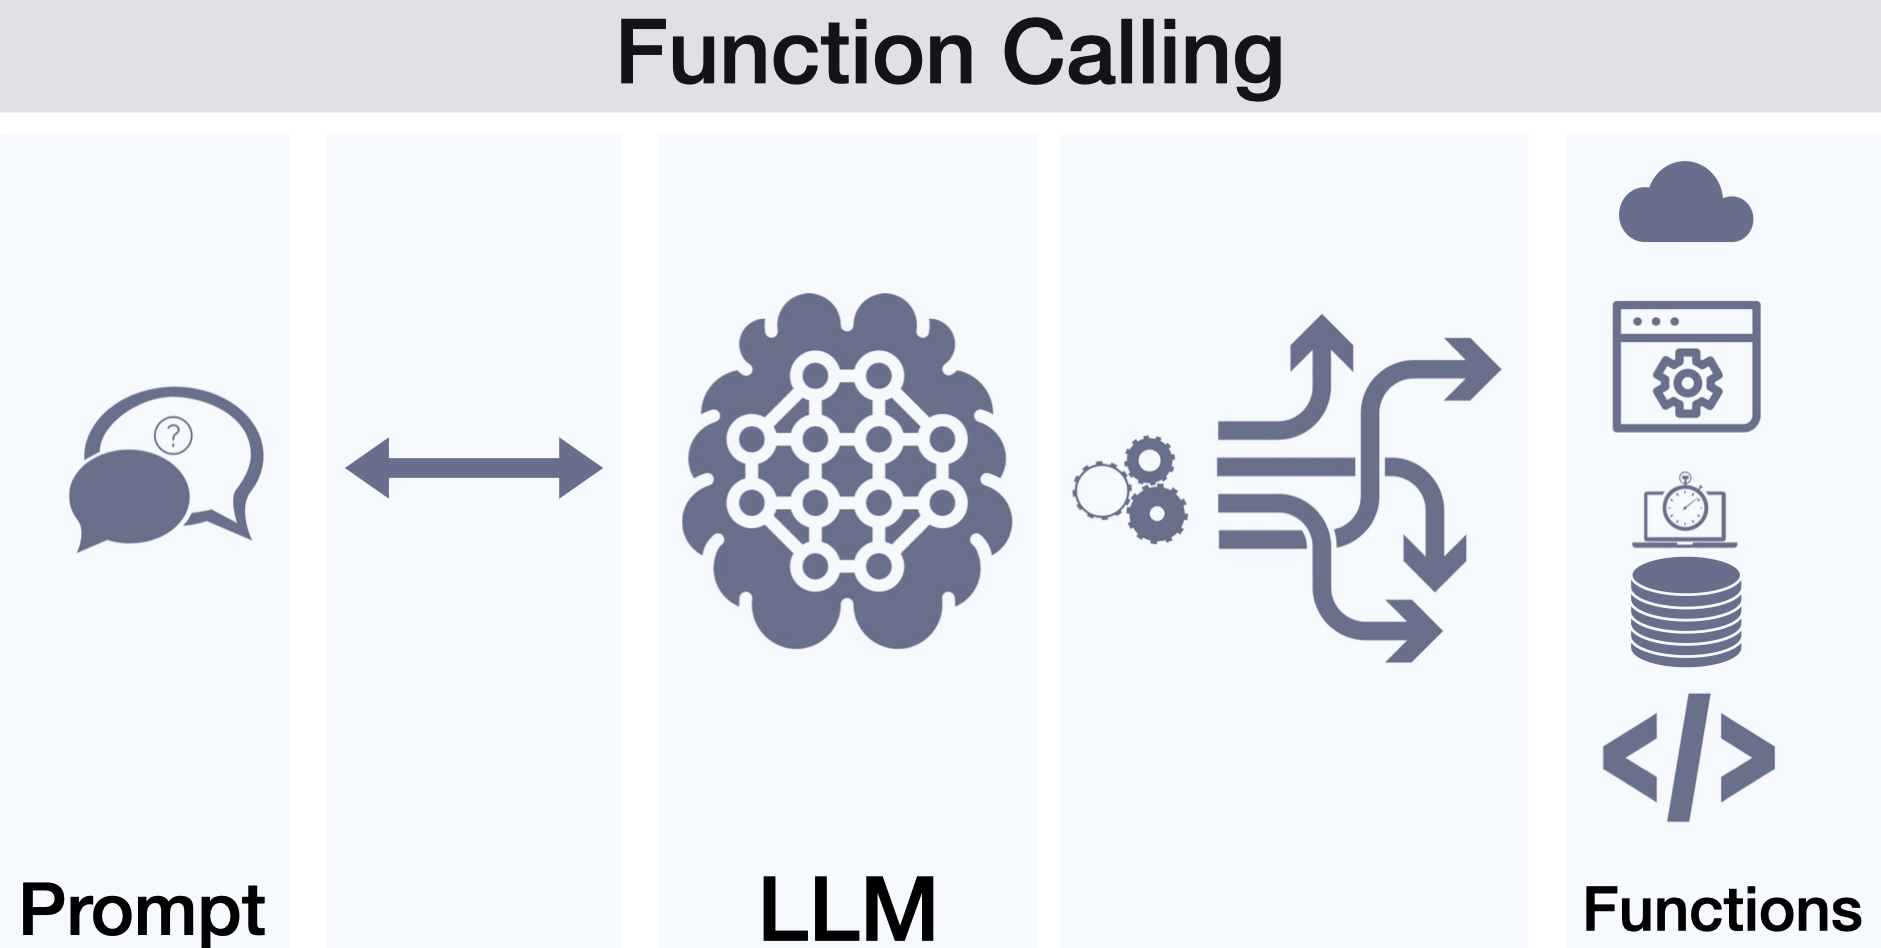

### Il Meccanismo di Funzionamento

Il function calling introduce un protocollo di comunicazione strutturato tra l'LLM e il tuo codice. 

**Fase 1: Setup (Una volta)**
```text
Sviluppatore → definisce funzioni Python
Sviluppatore → descrive funzioni in formato JSON
Sviluppatore → passa descrizioni all'LLM
```

**Fase 2: Runtime (Ogni richiesta)**
```text
1. Utente fa una domanda
2. LLM analizza la domanda + le funzioni disponibili
3. LLM decide se servono funzioni
   → Se NO: risponde direttamente
   → Se SÌ: genera chiamata funzione in JSON
4. Il codice riceve il JSON
5. Il codice esegue la funzione reale
6. Il codice ritorna il risultato all'LLM
7. LLM integra il risultato nella risposta finale
8. Utente riceve risposta completa
```

**Esempio di Chiamata Funzione Generata dall'LLM:**
```json
{
  "function": "calculator",
  "arguments": {
    "operation": "multiply",
    "num1": 45,
    "num2": 67
  }
}
```


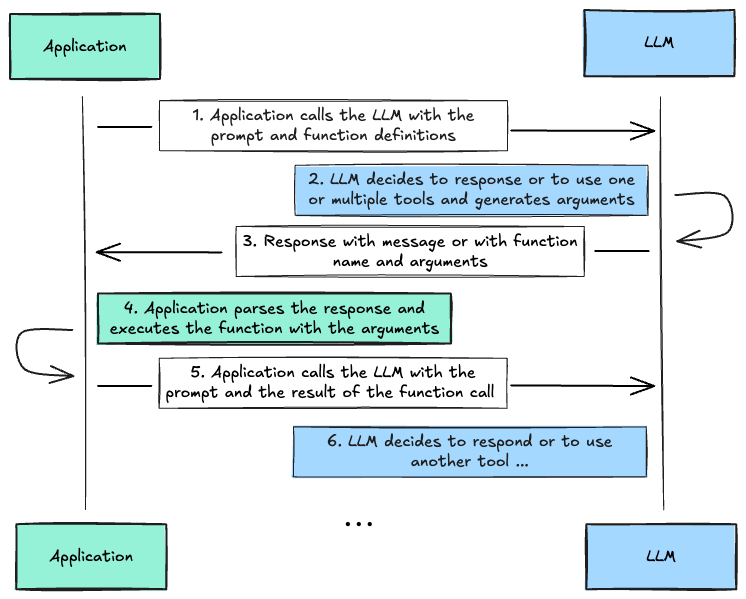

### Perché il Function Calling è Rivoluzionario

**1. Elimina le Allucinazioni per Dati Fattuali**

Gli LLM sono probabilistici e possono "inventare" dati. Con function calling, i dati fattuali provengono da fonti affidabili:
- Database aziendali
- API ufficiali
- Sistemi di record

**2. Trasforma l'LLM in un Agente**

Non più solo un chatbot che risponde, ma un agente che può:
- Leggere dati
- Modificare stati
- Orchestrare workflow
- Prendere decisioni e agire

**3. Integrazione Senza Limiti**

Puoi connettere l'LLM a qualsiasi sistema:
- Il tuo CRM custom
- Database proprietari
- API interne
- Microservizi esistenti

**4. Determinismo Dove Serve**

Le operazioni critiche (pagamenti, modifiche database) sono eseguite da codice testato e deterministico, non da output probabilistico dell'LLM.


### Comprendere i Modelli LLM

Non tutti i modelli di ollama supportano il function calling. È una capacità che richiede addestramento specifico. Il modello deve imparare a:
- Riconoscere quando serve una funzione
- Generare JSON strutturato correttamente
- Interpretare i risultati delle funzioni

**Modelli Raccomandati per Function Calling:**

| Modello | Dimensione | RAM Necessaria | Velocità | Qualità F.C. |
|---------|------------|----------------|----------|--------------|
| llama3.2:3b | ~2GB | 4GB | ⚡⚡⚡ | ⭐⭐⭐ |
| mistral | ~4GB | 8GB | ⚡⚡ | ⭐⭐⭐⭐ |
| llama3.1:8b | ~5GB | 10GB | ⚡⚡ | ⭐⭐⭐⭐⭐ |


## 2. Esempi di Funzioni Semplici

In [ ]:
from ollama import Client



MODEL = 'llama3.2:3b'



class SimpleAgent:
    def __init__(self, top_p = 1.0):
        self.client =  Client(host='http://localhost:11434')



    def chat(self,  messages: list[dict]):
        response = self.client.chat(
            model=MODEL,
             messages=messages
        )
        return response["message"]["content"]



    def tools(self, messages: list[dict], tools: list[dict]):
        return self.client.chat(
                model=MODEL,
                messages=messages,
                tools=tools
            )

    

### Esempio 1: Calcolatrice

Architettura della Soluzione

La nostra soluzione avrà tre layer:

```text
┌─────────────────────────────────┐
│  Layer 3: Interaction Loop      │  ← Gestisce chat LLM ↔ Function
├─────────────────────────────────┤
│  Layer 2: Tool Definition       │  ← Descrive funzione all'LLM
├─────────────────────────────────┤
│  Layer 1: Python Function       │  ← Esegue calcolo reale
└─────────────────────────────────┘
```

####  Layer 1: La Funzione Python

Di seguito è implementata una normale funzione Python. Non c'è niente di "AI" o "speciale". 
Questa tecnica è quindi possibile graize al fatto che un testo formale come il json viene usato come intermediario.

In [ ]:
def calculator(operation: str, num1: float, num2: float) -> float:
    """
    Esegue operazioni aritmetiche base.
    
    Args:
        operation: Una tra 'add', 'subtract', 'multiply', 'divide'
        num1: Primo numero
        num2: Secondo numero
    
    Returns:
        Risultato dell'operazione
    """

    # Convert to float to handle string inputs
    num1 = float(num1)
    num2 = float(num2)

    operations = {
        'add': num1 + num2,
        'subtract': num1 - num2,
        'multiply': num1 * num2,
        'divide': num1 / num2 if num2 != 0 else None
    }
    return operations.get(operation)

#### Layer 2: Tool Definition (Lo Schema JSON)

Ora dobbiamo dire all'LLM che questa funzione esiste. Usiamo un formato JSON standardizzato

|N.B| Lo schema dell'API che definisce la ***function calling*** è standard a meno di estensioni proprietarie
https://platform.openai.com/docs/guides/function-calling

In [ ]:
def calcuator_tool() -> dict:
    return {
        'type': 'function',
        'function': {
            'name': 'calculator',
            'description': 'Performs basic arithmetic operations (add, subtract, multiply, divide)',
            'parameters': {
                'type': 'object',
                'properties': {
                    'operation': {
                        'type': 'string',
                        'enum': ['add', 'subtract', 'multiply', 'divide'],
                        'description': 'The arithmetic operation to perform'
                    },
                    'num1': {
                        'type': 'number',
                        'description': 'The first number'
                    },
                    'num2': {
                        'type': 'number',
                        'description': 'The second number'
                    }
                },
                'required': ['operation', 'num1', 'num2']
            }
        }
    }



**Anatomia dello Schema:**

1. **type**: `'function'` - Dice che questo è un tool chiamabile
2. **name**: `'calculator'` - Nome che l'LLM userà per chiamare il tool
3. **description**: Descrizione in linguaggio naturale di cosa fa - MOLTO IMPORTANTE!
4. **parameters**: Definizione completa dei parametri in formato JSON Schema
   - **type**: `'object'` - I parametri sono un oggetto JSON
   - **properties**: Dizionario che definisce ogni parametro
   - **required**: Array di parametri obbligatori

**Perché 'enum' per operation?**

Limitare i valori possibili a un set predefinito:
- Previene errori (LLM non può inventare "moltiplicazione2")
- Rende il codice più robusto
- Aiuta l'LLM a scegliere il valore corretto


**La Description è Cruciale!**

L'LLM usa la description per decidere QUANDO chiamare il tool. Una buona description:
- Buona descrizione: "Esegue operazioni aritmetiche base (add, subtract, multiply, divide)"
- Descrizione troppo vaga: "Fa calcoli"

#### Layer 3: Loop di Interazione

In [ ]:
def agent_calculator(user_message):
    agent = SimpleAgent()


    messages = [{'role': 'user', 'content': user_message}]
    tools = [calcuator_tool()]

    response = agent.tools(messages, tools)
    
    #  Controlla se il modello vuole usare un tool
    if response['message'].get('tool_calls'):
        # Aggiungiela risposta del modello ai messaggi
        messages.append(response['message'])

        # Processa ogni chiamata al tool
        for tool_call in response['message']['tool_calls']:
            function_name = tool_call['function']['name']
            arguments = tool_call['function']['arguments']
            
            print(f" Chiamata funzione: {function_name}")
            print(f" Argomenti: {arguments}")
            
            # Esegue la funzione
            if function_name == 'calculator':
                result = calculator(**arguments)
                
                # Aggiung3 il risultato della funzione ai messaggi
                messages.append({
                    'role': 'tool',
                    'content': str(result)
                })

        # Ottieni la risposta finale con i risultati        
        final_response = agent.chat(messages)
        return final_response

    # Nessun tool necessario, risposta diretta    
    return response['message']['content']

In [ ]:
def agemt_calculator_test():
     # Test 1: Moltiplicazione
    print("TEST 1: Moltiplicazione")
    print(agent_calculator("Quanto fa 45 moltiplicato per 67?"))
    print("\n" + "="*50 + "\n")
    
    # Test 2: Sottrazione con contesto
    print("TEST 2: Sottrazione con contesto")
    print(agent_calculator("Se ho 1234 mele e ne regalo 567, quante me ne rimangono?"))
    
agemt_calculator_test()

**Cosa Notiamo:**

1. L'LLM condifica che "moltiplicato per" → operation='multiply'
2. Estrae correttamente i numeri dal testo
3. Chiama la funzione
4. Integra il risultato in una risposta naturale

### Esempio 2: Funzione Meteo Simulata
Aggiungiamo un secondo tool per dimostrare la gestione di tool multipli:


In [ ]:
import random
from datetime import datetime


import random
from datetime import datetime

def get_weather(location: str, unit: str = "celsius") -> dict:
    """
    Ottiene informazioni meteo per una località.
    
    Args:
        location: Nome della città
        unit: Unità di temperatura ('celsius' o 'fahrenheit')
    
    Returns:
        Dizionario con informazioni meteo
    """
    # Simuliamo dati meteo (in una app reale, chiameremmo un'API)
    conditions = ['soleggiato', 'nuvoloso', 'piovoso', 'parzialmente nuvoloso']
    temp_c = random.randint(10, 30)
    temp_f = (temp_c * 9/5) + 32
    
    return {
        'location': location,
        'temperature': temp_f if unit == 'fahrenheit' else temp_c,
        'unit': unit,
        'condition': random.choice(conditions),
        'humidity': random.randint(30, 90),
        'timestamp': datetime.now().isoformat()
    }

|N.B|
`unit` ha un default='celsius', ma non è in `required`. L'LLM può omettere questo parametro e la funzione Python userà il default definito nella firma (`unit: str = "celsius"`).

#### Definizione Tool Meteo


In [ ]:
def weather_tool():
    return  {
    'type': 'function',
    'function': {
        'name': 'get_weather',
        'description': 'get current weather information for a specific location',
        'parameters': {
            'type': 'object',
            'properties': {
                'location': {
                    'type': 'string',
                    'description': 'The name of the city, e.g., "Milan" or "Rome"'
                },
                'unit': {
                    'type': 'string',
                    'enum': ['celsius', 'fahrenheit'],
                    'description': 'Temperature unit',
                    'default': 'celsius'
                }
            },
            'required': ['location']  # unit is optional
        }
    }
}


#### Gestione Multi-Tool

|N.B| Usare un dizionario per mappare nomi a funzioni è un pattern Python comune e pulito:
```python
function_map = {
    'calculator': calculator,
    'get_weather': get_weather
}

# Chiamata dinamica
func = function_map['calculator']
result = func(operation='add', num1=2, num2=3)
```

In [ ]:
import json

def simple_agent_multi_tool(user_message: str):
    agent = SimpleAgent()

    # crea la lista con i dictionary relativi ai tool
    all_tools = [calcuator_tool(), weather_tool()]
    messages = [{'role': 'user', 'content': user_message}]

    response = agent.tools(messages, all_tools)


    # Mappa: nome funzione → funzione Python
    function_map = {
            'calculator': calculator,
            'get_weather': get_weather
        }
    


    if response['message'].get('tool_calls'):
        messages.append(response['message'])
        
        #  L'LLM può chiamare MULTIPLI tool in una singola risposta!
        for tool_call in response['message']['tool_calls']:
            function_name = tool_call['function']['name']
            arguments = tool_call['function']['arguments']
            

            # Trova ed esegui la funzione appropriata
            function_to_call = function_map.get(function_name)
            if function_to_call:
                result = function_to_call(**arguments)
                messages.append({
                    'role': 'tool',
                    'content': json.dumps(result)  # Converti dict a JSON string
                })
        
        # Ottieni la risposta finale con i risultati        
        final_response = agent.chat(messages)
        return final_response
    
    # Nessun tool necessario, risposta diretta    
    return response['message']['content']

#### Test Multi-Tool

In [ ]:
def simple_agent_multi_tool_test():

    # crea la lista con i dictionary relativi ai tool
    all_tools = [calcuator_tool, weather_tool]

    print(simple_agent_multi_tool( "Che tempo fa a Parigi? E quanto fa 25 per 4?"))
    
simple_agent_multi_tool_test()

## 3. Comprendere il Workflow dei Tool

Quando l'utente fa una richiesta che richiede un tool, avviene un'interazione complessa tra LLM e il codice. 
Comprendere questo flusso è essenziale per:
- Debug efficace
- Ottimizzare performance
- Gestire errori correttamente

```text
Utente: "Calcola 45 * 67"
    ↓
LLM riceve: messaggio + tool definitions
    ↓  
LLM analizza: "Serve calculator tool"
    ↓
LLM genera: {"function": "calculator", "arguments": {"operation": "multiply", "num1": 45, "num2": 67}}
    ↓
Python esegue: calculator("multiply", 45, 67) → 3015
    ↓
Python ritorna: "3015" (come tool message)
    ↓
LLM integra: "45 moltiplicato per 67 fa 3015"
    ↓
Utente riceve: risposta finale
```

### Pattern di Interazione Comuni

**Pattern 1: Single Tool**
```python
# Una domanda → un tool → una risposta
"Che tempo fa?" → get_weather() → "Soleggiato, 22°C"
```

**Pattern 2: Sequential Tools**
```python
# L'LLM chiama tool in sequenza
"Cerca laptop economici e calcola il totale"
→ search_products(max_price=500) → [laptop1, laptop2]
→ calculate_total([laptop1, laptop2]) → 850
→ "Ho trovato 2 laptop per un totale di €850"
```

**Pattern 3: Iterative Refinement**
```python
# L'LLM raffina basandosi sui risultati
"Trova il prodotto più economico"
→ get_categories() → ["Electronics", "Furniture", ...]
→ search_products(category="Electronics", sort="price") → risultati
→ get_product_by_id(cheapest_id) → dettagli
→ "Il prodotto più economico è..."
```

## 5. Esempi Complessi con SQLite

Una delle appplicazioni più complesse e interessanti di questo "paradigma" di prompt engineering è l'amministrazione automatica di un database.

### Scenario Realistico: Sistema Inventario

Costruiremo un sistema completo di gestione inventario che dimostra:
- Query dinamiche con filtri multipli
- Operazioni CRUD (Create, Read, Update, Delete)
- Transazioni e gestione stato
- Validazione e gestione errori

### Step 1: Setup del Database

Sqlite è già integrato nella libreria standard di python.

**Link utili**:
- https://sqlite.org/
- https://www.geeksforgeeks.org/python/python-sqlite/


|N.B.| In questo esempio verrà usato pathlib, una risorsa estremamente utile quando si tratta di gestire i file attraverso path sicuri

https://realpython.com/python-pathlib/

```bash
pip install pathlib
```

In [ ]:
import sqlite3

from pathlib import Path

CURRENT_DIR = Path("__ file__").parent.resolve()
DB_DIR =CURRENT_DIR / "db"

def init_products_database():
    conn = sqlite3.connect(DB_DIR / 'products.db')
    cursor = conn.cursor()
    

    cursor.execute('''
        CREATE TABLE IF NOT EXISTS products (
            id INTEGER PRIMARY KEY,
            name TEXT NOT NULL,
            category TEXT NOT NULL,
            price REAL NOT NULL,
            stock INTEGER NOT NULL,
            description TEXT
        )
    ''')
    
    # Dati realistici per test
    products = [
        (1, 'Laptop Pro 15', 'Electronics', 1299.99, 45, 
         'Laptop ad alte prestazioni con 16GB RAM'),
        (2, 'Mouse Wireless', 'Electronics', 29.99, 150, 
         'Mouse wireless ergonomico'),
        (3, 'Sedia da Ufficio', 'Furniture', 249.99, 30, 
         'Sedia da ufficio ergonomica regolabile'),
        (4, 'Lampada da Scrivania', 'Furniture', 45.50, 75, 
         'Lampada LED da scrivania con luminosità regolabile'),
        (5, 'Cavo USB-C', 'Electronics', 12.99, 200, 
         'Cavo di ricarica USB-C da 2m'),
        (6, 'Set Quaderni', 'Stationery', 15.99, 100, 
         'Set di 3 quaderni a righe'),
        (7, 'Scrivania Standing', 'Furniture', 399.99, 20, 
         'Scrivania elettrica regolabile in altezza'),
        (8, 'Tastiera Meccanica', 'Electronics', 89.99, 60, 
         'Tastiera meccanica RGB'),
    ]
    
    cursor.executemany(
        'INSERT OR REPLACE INTO products VALUES (?, ?, ?, ?, ?, ?)',
        products
    )
    
    conn.commit()
    conn.close()

    # RICORDARSI DI CHIUDERE LA CONNESSIONE AL DB
    conn.close()



### Step 2: Le Funzioni Python (Tool Functions)


**Punti Chiave:**
- **Query Parametrizzata**: Previene SQL injection
- **Filtri Opzionali**: Massima flessibilità
- **Ritorno Strutturato**: Dizionari facili da serializzare

In [ ]:

from typing import Optional


# -----------------------------------------------------
# FUNZIONE 1: Ricerca Prodotti con Filtri Multipli
# -----------------------------------------------------

def search_products(
    query: Optional[str] = None,
    category: Optional[str] = None,
    max_price: Optional[float] = None,
    min_stock: Optional[int] = None
) -> list[dict]:
    """
    Cerca prodotti con filtri flessibili.
    
    Args:
        query: Testo da cercare in nome/descrizione
        category: Filtra per categoria esatta
        max_price: Prezzo massimo inclusivo
        min_stock: Stock minimo inclusivo
    
    Returns:
        Lista di dict con info prodotti
    """
    conn = sqlite3.connect(DB_DIR / 'products.db')
    cursor = conn.cursor()
    
    # Costruzione query dinamica - PATTERN IMPORTANTE!
    sql = 'SELECT id, name, category, price, stock, description FROM products WHERE 1=1'
    params = []
    
    # Aggiunge filtri solo se specificati
    if query:
        sql += ' AND (name LIKE ? OR description LIKE ?)'
        search_term = f'%{query}%'
        params.extend([search_term, search_term])
    
    if category:
        sql += ' AND category = ?'
        params.append(category)
    
    if max_price is not None:
        sql += ' AND price <= ?'
        params.append(max_price)
    
    if min_stock is not None:
        sql += ' AND stock >= ?'
        params.append(min_stock)
    
    # Esegue query con parametri (SICURO contro SQL injection)
    cursor.execute(sql, tuple(params))
    rows = cursor.fetchall()
    conn.close()
    
    # Converte righe in dizionari
    results = []
    for row in rows:
        results.append({
            'id': row[0],
            'name': row[1],
            'category': row[2],
            'price': row[3],
            'stock': row[4],
            'description': row[5]
        })
    
    return results


# -----------------------------------------------
# FUNZIONE 2: Ottieni Prodotto Singolo per ID
# -----------------------------------------------

def get_product_by_id(product_id: int) -> Optional[dict]:
    """
    Ottiene dettagli completi di un singolo prodotto.
    
    Args:
        product_id: L'ID univoco del prodotto
    
    Returns:
        Dict con info prodotto, o None se non trovato
    """
    conn = sqlite3.connect(DB_DIR / 'products.db')
    cursor = conn.cursor()
    
    cursor.execute(
        'SELECT id, name, category, price, stock, description FROM products WHERE id = ?',
        (product_id,)
    )
    row = cursor.fetchone()
    conn.close()
    
    if row:
        return {
            'id': row[0],
            'name': row[1],
            'category': row[2],
            'price': row[3],
            'stock': row[4],
            'description': row[5]
        }
    return None


# ----------------------------------------------
# FUNZIONE 3: Aggiorna Stock con Validazione
# ----------------------------------------------

def update_stock(product_id: int, quantity_change: int) -> dict:
    """
    Aggiorna stock di un prodotto.
    
    Args:
        product_id: ID prodotto da aggiornare
        quantity_change: Delta (+aggiungi, -rimuovi)
    
    Returns:
        Dict con stato aggiornamento
    """
    conn = sqlite3.connect(DB_DIR / 'products.db')
    cursor = conn.cursor()
    
    # 1. Ottiene stock corrente
    cursor.execute('SELECT stock, name FROM products WHERE id = ?', (product_id,))
    result = cursor.fetchone()
    
    if not result:
        conn.close()
        return {
            'success': False,
            'error': 'Prodotto non trovato',
            'product_id': product_id
        }
    
    current_stock, name = result
    new_stock = current_stock + quantity_change
    
    # 2. Valida: non permettere stock negativo
    if new_stock < 0:
        conn.close()
        return {
            'success': False,
            'error': 'Stock insufficiente',
            'current_stock': current_stock,
            'requested_change': quantity_change
        }
    
    # 3. Applica aggiornamento
    cursor.execute(
        'UPDATE products SET stock = ? WHERE id = ?',
        (new_stock, product_id)
    )
    conn.commit()
    conn.close()
    
    # 4. Ritorna conferma dettagliata
    return {
        'success': True,
        'product_id': product_id,
        'product_name': name,
        'previous_stock': current_stock,
        'new_stock': new_stock,
        'change': quantity_change
    }

# -------------------------------
# FUNZIONE 4: Lista Categorie
# -------------------------------

def get_categories() -> list[str]:
    """
    Ottiene lista categorie uniche nel database.
    
    Returns:
        Lista di nomi categorie ordinate alfabeticamente
    """
    conn = sqlite3.connect(DB_DIR / 'products.db')
    cursor = conn.cursor()
    
    cursor.execute('SELECT DISTINCT category FROM products ORDER BY category')
    categories = [row[0] for row in cursor.fetchall()]
    
    conn.close()
    return categories

### Step 3: Definizioni Tool per l'LLM (LA PARTE CRUCIALE!)

Ora dobbiamo dire all'LLM che queste funzioni esistono. Creiamo gli schemi JSON:

In [ ]:
def get_db_tools():
    return [
    # TOOL 1: Search Products
    {
        'type': 'function',
        'function': {
            'name': 'search_products',
            'description': '''Search products in the inventory using multiple optional filters.
            
            Use this tool when the user wants to:
            - Find products by name or description
            - Filter by category
            - Find products within a price range
            - Check stock availability
            
            Returns: A list of products with ID, name, category, price, stock, and description.
            Note: If no filters are specified, ALL products are returned.''',
            'parameters': {
                'type': 'object',
                'properties': {
                    'query': {
                        'type': 'string',
                        'description': 'Text to search within product names and descriptions. Supports partial matching (e.g., "lap" matches "laptop").'
                    },
                    'category': {
                        'type': 'string',
                        'description': 'Filter by exact category. Possible values: "Electronics", "Furniture", "Stationery".'
                    },
                    'max_price': {
                        'type': 'number',
                        'description': 'Maximum price in euros (inclusive). Example: 100 shows products ≤ €100.'
                    },
                    'min_stock': {
                        'type': 'integer',
                        'description': 'Minimum required stock level. Useful for finding products with sufficient availability.'
                    }
                },
                'required': []  # ALL PARAMETERS ARE OPTIONAL
            }
        }
    },
    
    # TOOL 2: Get Product By ID
    {
        'type': 'function',
        'function': {
            'name': 'get_product_by_id',
            'description': '''get detailed information about a specific product using its unique ID.
            
            Use this tool when:
            - The user asks for details like "the first product", "the one with ID 5", etc.
            - After a search, the user wants to explore a specific result in depth
            - You need to verify a product’s existence before performing operations
            
            Returns: A complete product dictionary, or None if the ID does not exist.''',
            'parameters': {
                'type': 'object',
                'properties': {
                    'product_id': {
                        'type': 'integer',
                        'description': 'The unique numeric ID of the product (positive integer).'
                    }
                },
                'required': ['product_id']  # ID IS REQUIRED
            }
        }
    },
    
    # TOOL 3: Update Stock
    {
        'type': 'function',
        'function': {
            'name': 'update_stock',
            'description': '''Update the stock level of a product.
            
            Use this tool when:
            - New supplies arrive (quantity_change is POSITIVE)
            - Products are sold or removed (quantity_change is NEGATIVE)
            - You need to correct inventory errors
            
            IMPORTANT:
            - POSITIVE numbers add to stock
            - NEGATIVE numbers reduce stock
            - Does not allow negative final stock (automatic validation)
            
            Returns: Confirmation with previous and new stock levels, or an error if the operation is invalid.''',
            'parameters': {
                'type': 'object',
                'properties': {
                    'product_id': {
                        'type': 'integer',
                        'description': 'ID of the product to update.'
                    },
                    'quantity_change': {
                        'type': 'integer',
                        'description': 'Quantity to add (+) or remove (-). Example: +50 adds 50 units, -10 removes 10 units.'
                    }
                },
                'required': ['product_id', 'quantity_change']  # BOTH REQUIRED
            }
        }
    },
    
    # TOOL 4: Get Categories
    {
        'type': 'function',
        'function': {
            'name': 'get_categories',
            'description': '''Retrieve a list of all available product categories in the inventory.
            
            Use this tool when:
            - The user asks "what categories do you have?"
            - You need valid values for category filtering
            - You want to display a menu of available categories
            
            Returns: A list of strings (category names) sorted alphabetically.''',
            'parameters': {
                'type': 'object',
                'properties': {},
                'required': []  # NO PARAMETERS REQUIRED
            }
        }
    }
]


**Analisi delle Definizioni:**

1. **Descrizioni Dettagliate**: Ogni tool ha description che spiega:
   - Cosa fa
   - Quando usarlo
   - Cosa ritorna
   - Note importanti

2. **Parametri Ben Documentati**: Ogni parametro ha:
   - Tipo chiaro (`string`, `number`, `integer`)
   - Description specifica
   - Esempi quando utile

3. **Required vs Optional**: Chiaro quali parametri sono obbligatori

### Step 4: La Funzione di Chat (Collega Tutto!)

La funzione che gestisce la conversazione LLM ↔ Database:

In [ ]:
def agent_database(user_message: str):
    agent = SimpleAgent()

    # crea la lista con i dictionary relativi ai tool
    database_tools = get_db_tools()
    messages = [{'role': 'user', 'content': user_message}]


    function_map = {
        'search_products': search_products,
        'get_product_by_id': get_product_by_id,
        'update_stock': update_stock,
        'get_categories': get_categories
    }

    # Limite iterazioni (previene loop infiniti)
    max_iterations = 5

    for iteration in range(max_iterations):
        # Chiamata all'LLM con i tool disponibili
        response = agent.tools(messages, database_tools)

        # Se l'LLM non ha elementi per selezionare un tool, abbiamo finito
        if not response['message'].get('tool_calls'):
            return response['message']['content']
        
        # L'LLM si attiva per usare uno o più tool!
        print(f"\n{'='*70}")
        print(f"ITERAZIONE {iteration 
                            + 1}")
        print(f"{'='*70}")

        # Aggiungi il messaggio dell'LLM 
        messages.append(response['message'])

        # Esegui TUTTI i tool richiesti dall'LLM

        for tool_call in response['message']['tool_calls']:
            function_name = tool_call['function']['name']
            arguments = tool_call['function']['arguments']

            print(f"\n - Tool Chiamato: {function_name}")
            print(f" - Argomenti: {json.dumps(arguments, indent=2)}")

            print(f"\n -Tool Chiamato: {function_name}")
            print(f" -Argomenti: {json.dumps(arguments, indent=2)}")

            # Trova ed esegui la funzione Python corrispondente
            function_to_call = function_map.get(function_name)

            if function_to_call:
                try:
                    # ESEGUI LA FUNZIONE!
                    result = function_to_call(**arguments)

                    # Mostra risultato (troncato se troppo lungo)
                    result_str = json.dumps(result, indent=2, ensure_ascii=False)
                    if len(result_str) > 300:
                        print(f"- Risultato: {result_str}...")
                    else:
                        print(f"- Risultato: {result_str}")
                    
                    # Aggiungi risultato alla storia per l'LLM
                    messages.append({
                        'role': 'tool',
                        'content': json.dumps(result)
                    })
                    
                except Exception as e:
                    error_msg = f"Errore esecuzione {function_name}: {str(e)}"
                    print(error_msg)

                    messages.append({
                        'role': 'tool',
                        'content': json.dumps({'error': error_msg})
                    })
            else:
                print(f" Funzione sconosciuta: {function_name}")
                
    return "Query troppo complessa - raggiunto limite iterazioni. Prova a semplificare la richiesta."

In [ ]:
# inizializza database
init_products_database()

In [ ]:
# TEST 1: Ricerca Semplice con Filtro
def agent_database_test_1():

    print("\n📦 TEST 1: Ricerca con filtro prezzo")
    print("-" * 80)
    result = agent_database(
        "Mostrami tutti gli articoli elettronici che costano meno di 100 euro"
    )
    print(f"\n💬 RISPOSTA FINALE:\n{result}")

agent_database_test_1()

In [ ]:
# TEST 2: Query Multi-Step (Ragionamento)
def agent_database_test_2():
    print("\n\n📦 TEST 2: Analisi multi-step")
    print("-" * 80)
    result = agent_database(
        "Che mobili abbiamo in inventario? Di questi, quali hanno stock sotto le 25 unità?"
    )
    print(f"\n💬 RISPOSTA FINALE:\n{result}")

agent_database_test_2()

In [ ]:
# TEST 3: Aggiornamento con Verifica
def agent_database_test_3():
    print("\n\n📦 TEST 3: Aggiornamento stock")
    print("-" * 80)
    result = agent_database(
        "Sono arrivati 50 mouse con product id Mouse Wireless in più. Aggiorna l'inventario e dimmi il nuovo totale."
    )
    print(f"\n💬 RISPOSTA FINALE:\n{result}")


agent_database_test_3()

In [ ]:
# TEST 4: Query Complessa con Calcoli
def agent_database_test_4():
    print("\n\n📦 TEST 4: Query con ragionamento complesso")
    print("-" * 80)
    result = agent_database('''
    Voglio allestire un nuovo ufficio con budget di 1500 euro.
    Mi servono: una scrivania, una sedia e una lampada.
    Trova le opzioni disponibili, calcola il totale e dimmi se il budget basta.
    ''')
    print(f"\n💬 RISPOSTA FINALE:\n{result}")

agent_database_test_4()